In [50]:
# Importing the Adult Dataset
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, KFold

In [51]:
df = pd.read_csv("adult.data", header=None)
headers = {0:"Age",1:"Workclass",2:"fnlwgt", 3:"Education", 4:"Education-num", 5:"Maritial-Status"
              , 6:"Occupation", 7:"Relationship", 8:"Race", 9:"Sex", 10:"Capital-Gain", 11:"Capital-Loss"
              , 12:"Hours-per-Week", 13:"Native-Country", 14:"Class"}
df = df.rename(columns=headers)

# Shape of Dataframe is (32561, 15)
df.head()

,Age,Workclass,fnlwgt,Education,Education-num,Maritial-Status,Occupation,Relationship,Race,Sex,Capital-Gain,Capital-Loss,Hours-per-Week,Native-Country,Class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [52]:
# One-Hot Encoding of Categorical Variables

# Drops Unecessary Columns
df = pd.get_dummies(df)
df = df.drop(['Workclass_ ?'], axis=1)
df = df.drop(['Class_ >50K'], axis=1)

df.head()

,Age,fnlwgt,Education-num,Capital-Gain,Capital-Loss,Hours-per-Week,Workclass_ Federal-gov,Workclass_ Local-gov,Workclass_ Never-worked,Workclass_ Private,...,Native-Country_ Puerto-Rico,Native-Country_ Scotland,Native-Country_ South,Native-Country_ Taiwan,Native-Country_ Thailand,Native-Country_ Trinadad&Tobago,Native-Country_ United-States,Native-Country_ Vietnam,Native-Country_ Yugoslavia,Class_ <=50K
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
2,38,215646,9,0,0,40,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1
3,53,234721,7,0,0,40,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1
4,28,338409,13,0,0,40,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


In [15]:
# 2) Split the dataset into 2 parts: 
#    (a) Training set + Validation set  (80% of all data points)
#    (b) Test set                       (20% of all data points)

X_train_val = X[:int(0.8*len(X))] # Get features from train + val set.
X_test      = X[int(0.8*len(X)):] # Get features from test set.     
Y_train_val = Y[:int(0.8*len(Y))] # Get labels from train + val set.
Y_test      = Y[int(0.8*len(Y)):] # Get labels from test set.  
print(X_train_val.shape, X_test.shape, Y_train_val.shape, Y_test.shape)

(280, 34) (71, 34) (280,) (71,)


In [16]:
# 3) Implement the k-NN.
class simple_KNeighborsClassifier(object):
    def __init__(self, k):
        """
        k-NN initialization.
            k: Number of nearest neighbors.
        """
        self.k = k
        
    def fit(self, X_train, Y_train):
        """
        k-NN fitting function.
            X_train: Feature vectors in training set.
            Y_train: Labels in training set.
        """
        self.X_train = X_train
        self.Y_train = Y_train
        
    def predict(self, X_pred):
        """
        k-NN prediction function.
            X_pred: Feature vectors in training set.
        Return the predicted labels for X_pred. Shape: (len(X_pred), )
        """
        Y_pred = []
        for i in range(len(X_pred)):
            distances = ((self.X_train - X_pred[i].reshape(1,-1)) \
                          ** 2.0).sum(axis = 1)
            distances_and_labels = [(distances[i], self.Y_train[i]) \
                                    for i in range(len(self.X_train))]
            distances_and_labels.sort()
            top_k_labels = np.array(distances_and_labels)[:self.k,1].ravel()
            mode, _ = scipy.stats.mode(top_k_labels)
            Y_pred.append(mode[0])
        return np.array(Y_pred)

In [17]:
# 4) Implement the cross-validation.

def simple_cross_validation(X_train_val, Y_train_val, k, fold):
    """
    A simple cross-validation function for k-NN.
    
    X_train_val: Features for train and val set. 
                 Shape: (num of data points, num of features)
    Y_train_val: Labels for train and val set.
                 Shape: (num of data points,)
    k:           Parameter k for k-NN.
    fold:        The number of folds to do the cross-validation.
    
    Return the average accuracy on validation set.
    """
    val_acc_list = []
    train_acc_list = []
    for i in range(fold):
        start       = int(i*len(X_train_val)/fold)
        end         = int((i+1)*len(X_train_val)/fold)
        index_train = list(range(0, start)) + list(range(end, len(X_train_val)))
        index_val   = range(start, end)
        X_train     = X_train_val[index_train]
        Y_train     = Y_train_val[index_train]
        X_val       = X_train_val[index_val]
        Y_val       = Y_train_val[index_val]
        #classifier  = KNeighborsClassifier(algorithm='brute', n_neighbors=k)
        classifier = simple_KNeighborsClassifier(k=k)
        classifier.fit(X_train, Y_train)
        val_acc_list.append(sum(classifier.predict(X_val) == Y_val) / len(X_val))
        train_acc_list.append(sum(classifier.predict(X_train) == Y_train) / len(X_train))
        
    return sum(val_acc_list) / len(val_acc_list), \
           sum(train_acc_list) / len(train_acc_list)

In [18]:
# 5) Implement the grid search function.

def simple_GridSearchCV_fit(X_train_val, Y_train_val, k_list, fold):
    """
    A simple grid search function for k with cross-validation in k-NN.
    
    X_train_val: Features for train and val set. 
                 Shape: (num of data points, num of features)
    Y_train_val: Labels for train and val set.
                 Shape: (num of data points,)
    k_list:      The list of k values to try.
    fold:        The number of folds to do the cross-validation.
    
    Return the val and train accuracy matrix of cross-validation. 
    All combinations of k are included in the array. 
    Shape: (len(k_list), )
    """
    val_acc_array = np.zeros(len(k_list))
    train_acc_array = np.zeros(len(k_list))
    for i in range(len(k_list)):
        val_acc_array[i], train_acc_array[i] = simple_cross_validation(
            X_train_val, Y_train_val, k_list[i], fold)
    return val_acc_array, train_acc_array

In [19]:
# 6) Perform grid search.

#k_list = [1,2,3,4,5,6]
k_list = [1,2,4,8,12,16,20,24,26]
val_acc_array, train_acc_array = \
    simple_GridSearchCV_fit(X_train_val, Y_train_val, k_list, 3)

In [20]:
# 7) Draw heatmaps for result of grid search and find 
#    best k on validation set.

def draw_heatmap_knn(acc, acc_desc, k_list):
    plt.figure(figsize = (2,4))
    ax = sns.heatmap(acc, annot=True, fmt='.3f', yticklabels=k_list, xticklabels=[])
    ax.collections[0].colorbar.set_label("accuracy")
    ax.set(ylabel='$k$')
    plt.title(acc_desc + ' w.r.t $k$')
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.show()
    
#
# You can use the draw_heatmap_knn() to draw a heatmap to visualize 
# the accuracy w.r.t. k. Some demo code is given below as hint:
#
# demo_acc        = np.array([[0.8],
#                             [0.7]])
# demo_k_list     = [1, 2]
# draw_heatmap_linear(demo_acc, 'demo accuracy', demo_k_list)
#

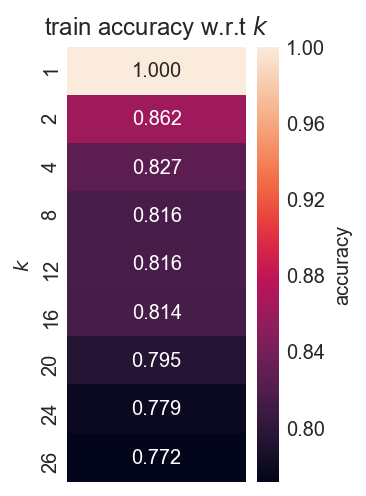

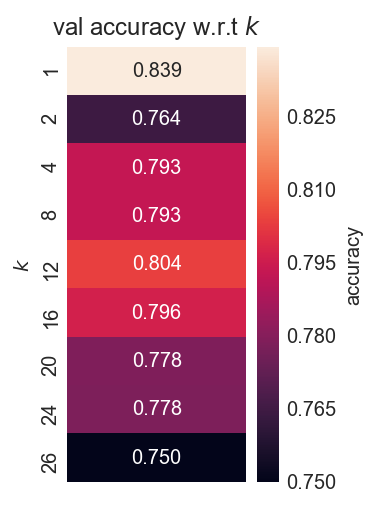

In [21]:
draw_heatmap_knn(train_acc_array.reshape(-1,1), 'train accuracy', k_list)
draw_heatmap_knn(val_acc_array.reshape(-1,1), 'val accuracy', k_list)

In [57]:
# 8) Use the best k to calculate the test accuracy.

classifier = simple_KNeighborsClassifier(k=1)
classifier.fit(X_train_val, Y_train_val)
sum(classifier.predict(X_test) == Y_test) / len(X_test)

0.91549295774647887

In [24]:
# 2) Split the dataset into 2 parts: 
#    (a) Training set + Validation set  (80% of all data points)
#    (b) Test set                       (20% of all data points)

X_train_val = X[:int(0.5*len(X))] # Get features from train + val set.
X_test      = X[int(0.5*len(X)):] # Get features from test set.     
Y_train_val = Y[:int(0.5*len(Y))] # Get labels from train + val set.
Y_test      = Y[int(0.5*len(Y)):] # Get labels from test set.  
print(X_train_val.shape, X_test.shape, Y_train_val.shape, Y_test.shape)

(175, 34) (176, 34) (175,) (176,)


In [25]:
# 3) Implement the k-NN.
class simple_KNeighborsClassifier(object):
    def __init__(self, k):
        """
        k-NN initialization.
            k: Number of nearest neighbors.
        """
        self.k = k
        
    def fit(self, X_train, Y_train):
        """
        k-NN fitting function.
            X_train: Feature vectors in training set.
            Y_train: Labels in training set.
        """
        self.X_train = X_train
        self.Y_train = Y_train
        
    def predict(self, X_pred):
        """
        k-NN prediction function.
            X_pred: Feature vectors in training set.
        Return the predicted labels for X_pred. Shape: (len(X_pred), )
        """
        Y_pred = []
        for i in range(len(X_pred)):
            distances = ((self.X_train - X_pred[i].reshape(1,-1)) \
                          ** 2.0).sum(axis = 1)
            distances_and_labels = [(distances[i], self.Y_train[i]) \
                                    for i in range(len(self.X_train))]
            distances_and_labels.sort()
            top_k_labels = np.array(distances_and_labels)[:self.k,1].ravel()
            mode, _ = scipy.stats.mode(top_k_labels)
            Y_pred.append(mode[0])
        return np.array(Y_pred)

In [28]:
# 6) Perform grid search.

#k_list = [1,2,3,4,5,6]
k_list = [1,2,4,8,12,16,20,24,26]
val_acc_array, train_acc_array = \
    simple_GridSearchCV_fit(X_train_val, Y_train_val, k_list, 3)

In [29]:
# 7) Draw heatmaps for result of grid search and find 
#    best k on validation set.

def draw_heatmap_knn(acc, acc_desc, k_list):
    plt.figure(figsize = (2,4))
    ax = sns.heatmap(acc, annot=True, fmt='.3f', yticklabels=k_list, xticklabels=[])
    ax.collections[0].colorbar.set_label("accuracy")
    ax.set(ylabel='$k$')
    plt.title(acc_desc + ' w.r.t $k$')
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.show()
    
#
# You can use the draw_heatmap_knn() to draw a heatmap to visualize 
# the accuracy w.r.t. k. Some demo code is given below as hint:
#
# demo_acc        = np.array([[0.8],
#                             [0.7]])
# demo_k_list     = [1, 2]
# draw_heatmap_linear(demo_acc, 'demo accuracy', demo_k_list)
#

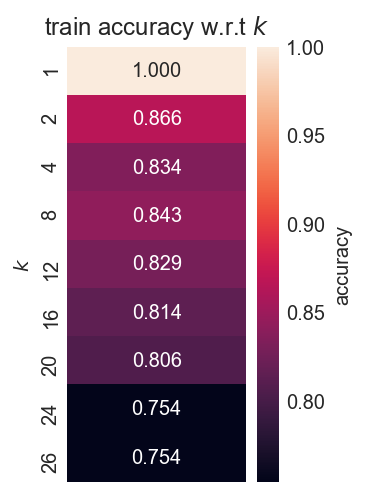

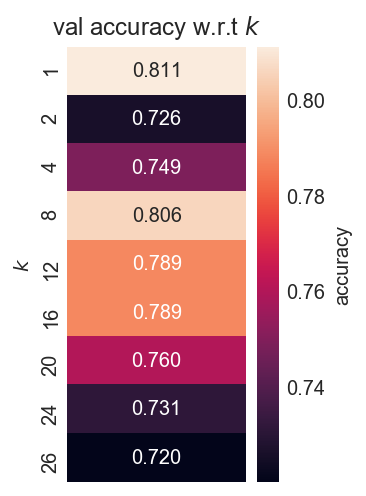

In [30]:
draw_heatmap_knn(train_acc_array.reshape(-1,1), 'train accuracy', k_list)
draw_heatmap_knn(val_acc_array.reshape(-1,1), 'val accuracy', k_list)

In [31]:
# 8) Use the best k to calculate the test accuracy.

classifier = simple_KNeighborsClassifier(k=1)
classifier.fit(X_train_val, Y_train_val)
sum(classifier.predict(X_test) == Y_test) / len(X_test)

0.86363636363636365

In [33]:
# 2) Split the dataset into 2 parts: 
#    (a) Training set + Validation set  (80% of all data points)
#    (b) Test set                       (20% of all data points)

X_train_val = X[:int(0.2*len(X))] # Get features from train + val set.
X_test      = X[int(0.2*len(X)):] # Get features from test set.     
Y_train_val = Y[:int(0.2*len(Y))] # Get labels from train + val set.
Y_test      = Y[int(0.2*len(Y)):] # Get labels from test set.  
print(X_train_val.shape, X_test.shape, Y_train_val.shape, Y_test.shape)

(70, 34) (281, 34) (70,) (281,)


In [38]:
# 7) Draw heatmaps for result of grid search and find 
#    best k on validation set.

def draw_heatmap_knn(acc, acc_desc, k_list):
    plt.figure(figsize = (2,4))
    ax = sns.heatmap(acc, annot=True, fmt='.3f', yticklabels=k_list, xticklabels=[])
    ax.collections[0].colorbar.set_label("accuracy")
    ax.set(ylabel='$k$')
    plt.title(acc_desc + ' w.r.t $k$')
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.show()
    
#
# You can use the draw_heatmap_knn() to draw a heatmap to visualize 
# the accuracy w.r.t. k. Some demo code is given below as hint:
#
# demo_acc        = np.array([[0.8],
#                             [0.7]])
# demo_k_list     = [1, 2]
# draw_heatmap_linear(demo_acc, 'demo accuracy', demo_k_list)
#

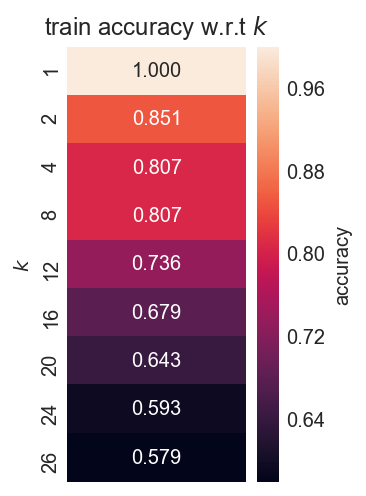

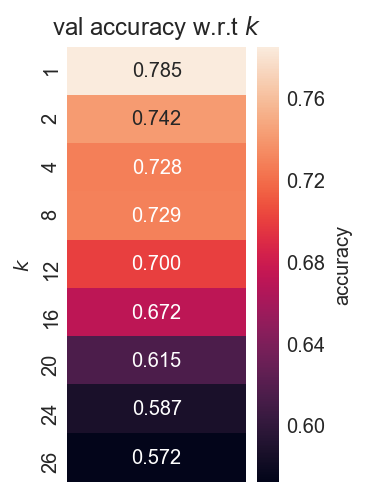

In [39]:
draw_heatmap_knn(train_acc_array.reshape(-1,1), 'train accuracy', k_list)
draw_heatmap_knn(val_acc_array.reshape(-1,1), 'val accuracy', k_list)

In [40]:
# 8) Use the best k to calculate the test accuracy.

classifier = simple_KNeighborsClassifier(k=1)
classifier.fit(X_train_val, Y_train_val)
sum(classifier.predict(X_test) == Y_test) / len(X_test)

0.83629893238434161

In [42]:
# 2) Split the dataset into 2 parts: 
#    (a) Training set + Validation set  (80% of all data points)
#    (b) Test set                       (20% of all data points)

X_train_val = X[:int(0.8*len(X))] # Get features from train + val set.
X_test      = X[int(0.8*len(X)):] # Get features from test set.     
Y_train_val = Y[:int(0.8*len(Y))] # Get labels from train + val set.
Y_test      = Y[int(0.8*len(Y)):] # Get labels from test set.  
print(X_train_val.shape, X_test.shape, Y_train_val.shape, Y_test.shape)

(280, 34) (71, 34) (280,) (71,)


In [46]:
# 6) Perform grid search.

#k_list = [1,2,3,4,5,6]
k_list = [1,2,4,8,12,16,20,24,26]
val_acc_array, train_acc_array = \
    simple_GridSearchCV_fit(X_train_val, Y_train_val, k_list, 3)

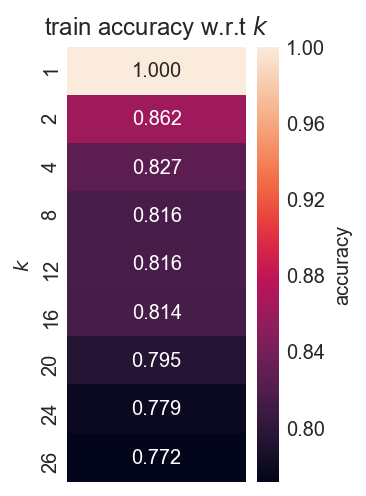

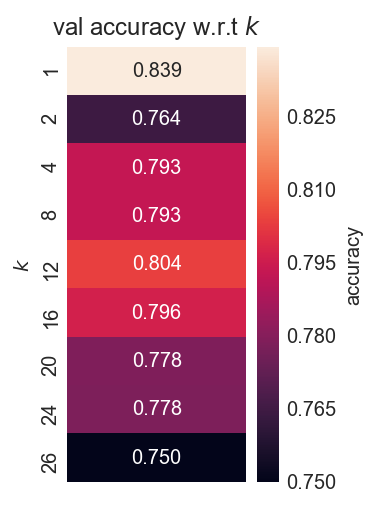

In [48]:
draw_heatmap_knn(train_acc_array.reshape(-1,1), 'train accuracy', k_list)
draw_heatmap_knn(val_acc_array.reshape(-1,1), 'val accuracy', k_list)

In [56]:
# 8) Use the best k to calculate the test accuracy.

classifier = simple_KNeighborsClassifier(k=1)
classifier.fit(X_train_val, Y_train_val)
sum(classifier.predict(X_test) == Y_test) / len(X_test)

0.91549295774647887